## Praca Domowa 4 - XAI

Wykorzystam model ```RandomForestClassifier``` użyty do klasyfikacji zestawu ```airline_satisfaction```.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

### Wczytanie danych i przygotowanie modelu

In [2]:
df_train = pd.read_csv('data/train.csv', index_col=0, keep_default_na=False)
df_train.drop('id', axis=1, inplace=True)
X_train, y_train = df_train.drop('satisfaction', axis=1), df_train['satisfaction']

df_test = pd.read_csv('data/test.csv', index_col=0, keep_default_na=False)
df_test.drop('id', axis=1, inplace=True)
X_test, y_test = df_test.drop('satisfaction', axis=1), df_test['satisfaction']


In [3]:
ct = ColumnTransformer(
    [
        ('ordinal_encoder', OrdinalEncoder(), [0, 1, 3, 4]),
        ('simple_imputer', SimpleImputer(missing_values='', strategy='constant', fill_value=0), [-1]) # Arrival Delay in minutes
    ],
    remainder='passthrough'
)
rfc = Pipeline(
    [
        ('column_transformer', ct),
        ('model', RandomForestClassifier(n_estimators=100, max_depth=25, min_samples_split=7.2e-05)) # hiperparametry wyznaczone w PD2
    ]
)

In [4]:
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.9627348321527563

Tutaj dodam, że oryginalny model z PD2 był inny, ponieważ dostrajałem go na zbiorze treningowym, a nie walidacyjnym :((. Jednak wykorzystując dokładnie tą samą metodę dostrajania uzyskałem powyższy model, z którego będę dalej korzystał. 

### Odtworzenie przetransformowanej ramki danych

Niestety po przejściu przez Pipeline każdy dataframe staje się tablicą numpy przez co tracimy nazwy kolumn.

In [5]:
X_train_processed = ct.fit_transform(X_train)
X_test_processed = ct.transform(X_test)

In [6]:
new_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Arrival Delay in Minutes', 'Age']
new_columns.extend(X_train.columns[5:-1])
X_train_processed = pd.DataFrame(X_train_processed, columns=new_columns)
X_test_processed = pd.DataFrame(X_test_processed, columns=new_columns)

### DALEX

Wpierw wykorzystam pakiet DALEX do analizy zachowania modelu dla pojedynczych obserwacji

In [7]:
import dalex as dx

In [ ]:
exp = dx.Explainer(rfc, X_train, y_train)

Weźmy kilka losowych osób

In [182]:
np.random.seed(42)
samples_idx = np.random.randint(len(X_test), size=4)
samples = X_test.iloc[samples_idx]

Jakie osoby wybraliśmy?

In [191]:
samples.iloc[0:, [0, 1, 2, 3, -1]]

,Gender,Customer Type,Age,Type of Travel,Arrival Delay in Minutes
23654,Female,Loyal Customer,62,Personal Travel,67.0
15795,Female,Loyal Customer,13,Personal Travel,0.0
860,Female,Loyal Customer,57,Business travel,0.0
5390,Male,Loyal Customer,36,Business travel,0.0


In [200]:
y_test[samples_idx]

23654    neutral or dissatisfied
15795    neutral or dissatisfied
860                    satisfied
5390                   satisfied
Name: satisfaction, dtype: object

Udało nam się wylosować całkiem ciekawą próbkę. Oprócz ```Customer Type``` (który w dużej większosci jest równy *Loyal Customer*) mamy różne wartości dla profilu osoby.

In [207]:
bd_sample_1 = exp.predict_parts(samples.iloc[0], type='break_down', label='Old Woman, Personal Flight, Delayed')

In [213]:
bd_sample_1.plot(max_vars = 22)

In [208]:
bd_sample_2 = exp.predict_parts(samples.iloc[1], type='break_down', label='Young Girl, Personal Flight')

In [214]:
bd_sample_2.plot(max_vars = 22)

In [209]:
bd_sample_3 = exp.predict_parts(samples.iloc[3], type='break_down', label='Adult Man, Business Flight')

In [215]:
bd_sample_3.plot(max_vars = 22)

### Analiza

Przede wszystkim możemy zauwayżyć, że jakość WiFi jest tutaj dość znacząca. Wartość poniżej 4 skutkuje obniżeniem satysfakcji.

Innym ważnym czynnikiem jest typ podróży. W obu pierwszych przypadkach typ ```Personal Travel``` obniżył satysfakcję natomiast ```Business Travel``` podwyższył ją w przypadku trzeciej osoby.

Bycie lojalnym klientem w każdym przypadku zwiększyło satysfakcję.

Co ciekawe według wykresu ponad godzina opóźnienia nie miała dużego wpływu na satysfakcję pierwszej osoby. Ten parametr warto by jednak sprawdzić dla podróży biznesowych, ponieważ tam stracony czas może mieć większe znaczenie.

W pierwszym i drugim przypadku znaczenie miał też aytrybut ```Online Boarding```.

Ogólnie większość atrybutów dokłada swoją małą cegiełkę do ogólnego wyniku. Oprócz pojedynczych zmiennych, które mają duży wpływ końcowa satysfakcja jest głównie wynikiem mniejszych lub większych udogodnień w trakcie lotu.

A jak wygląda **feature importance** wyznaczone przez RFC?

In [220]:
rfc_fi = pd.DataFrame(data=dict(feature=new_columns, importance=rfc._final_estimator.feature_importances_)).sort_values(by='importance', ascending=False)

In [226]:
px.bar(x=rfc_fi['feature'], y=rfc_fi['importance'])

Faktycznie widzimy dostępność WiFi oraz typ podróży, a także ```Online boarding``` wysoko na wykresie. Opowiadają one za 43.7% całego rozkładu. 
Pierwsze pięć atrybutów odpowiada za prawie 60%.

### SHAP

In [8]:
import shap

In [36]:
explainer = shap.Explainer(rfc._final_estimator)
shap_values = explainer(ct.transform(X_test)[:250,:])

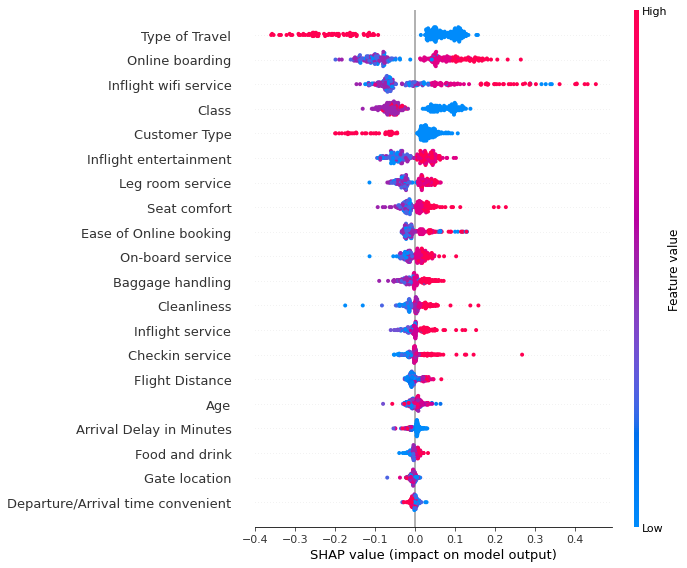

In [38]:
shap.summary_plot(shap_values[:,:,1], ct.transform(X_test)[:250,:], feature_names=np.array(new_columns))

### Analiza

SHAP wyznacza podobne atrybuty jako te najlepiej wyjaśniające działanie modelu. Znów ```Type of Travel``` jest w czołówce.
Widać, że osoby podróżujące w celach biznesowych (niebieski) mają z reguły lepszą satysfakcję z lotu. Jest to jednak niewielki wzrost.
Z kolei osoby podróżujące prywatnie z reguły nie bawią się aż tak dobrze i tutaj wariancja wpływu na satysfakcję jest znacznie większa.

Ponownie widzimy korelację między dostępem do WiFi a satysfakcją. Tyczy się to także innych udogodnień (jak komfort, miejsce na nogi czy czystość).

Ponownie ciekawym jest brak większego wpływu opóźnień na satysfakcję lotu. Co nie zmienia faktu, że loty opóźnione nie cieszą się zwiększoną satysfakcją.

### Podsumowanie

Ostatecznie można stwierdzić, że model w szczególności bierze pod uwagę

- Type of Travel
- Online boarding
- Inflight WiFi
- Class
- Customer Type

Udogodnienia w trakcie lotu mają mniejsze pojedyncze znaczenie jednak łącznie są ważnym czynnikiem.

Mniejsze znaczenie mają atrybuty związane z czekaniem i wsiadaniem do samolotu. W szczególności zaskakująco mało ważne jest opóźnienie.